### EDA

In [57]:
library(cowplot) #Installing package into 'C:/Users/User/Documents/R/win-library/4.0'
library(grid)
library(ggplot2)
library(ggExtra)
library(tidyverse)
library(lubridate)
library(gridExtra)
library(tableone)

In [2]:
# directories
datadir = "../../DataTD"
cohortdir = "../../OutputTD/1_cohort"
featuredir = "../../OutputTD/2_features"
figuredir = "../../OutputTD/Figures"
modeldir4 = "../../OutputTD/3_models/1_4_cohort"
# modeldir4preadmit = "../../OutputTD/3_models/1_4_cohort_24hrpreadmit"
tabledir = "../../OutputTD/4_tables"
resultdir = "../../OutputTD/5_results_analysis"

options(repr.matrix.max.rows=200, repr.matrix.max.cols=30)

In [49]:
cohort <- read.csv(file.path(cohortdir, "1_4_cohort.csv")) %>% mutate(admit_time = ymd_hms(admit_time))
nrow(cohort)

demo <- read.csv(file.path(featuredir, "2_1_coh2_demo.csv"))  %>% mutate(admit_time = ymd_hms(admit_time)) 
nrow(demo)

esi <- read.csv(file.path(featuredir, "2_5_coh3_imputedHWESI.csv"))  %>% mutate(admit_time = ymd_hms(admit_time)) %>%
            select(anon_id, pat_enc_csn_id_coded, ESI_i) %>% rename(ESI = ESI_i)
nrow(esi)

los1 <- read.csv(file.path(resultdir, "01_length_of_stay_in_ED.csv"))#%>% mutate(admit_time = ymd_hms(admit_time))
nrow(los1) # less 1 than cohort

los2 <- read.csv(file.path(resultdir, "5_2_length_of_stay_labels.csv")) %>% mutate(admit_time = ymd_hms(admit_time))
nrow(los2) # same size!
# adm_year = year(admit_time)

[1] 43980

[1] 45794

[1] 44258

[1] 43979

[1] 43980

In [48]:
demo %>% group_by(race) %>% summarize(n=n())

`summarise()` ungrouping output (override with `.groups` argument)



race,n
<chr>,<int>
Asian,6870
Black,3260
Native American,195
Other,10511
Pacific Islander,930
Unknown,424
White,23604


In [12]:
head(demo, 1)
head(esi, 1)
colnames(cohort)
head(cohort, 1)
# end date is death date if patient died in the hospital, otherwise, it's discharge date
colnames(los2)
head(los2, 1)

,anon_id,pat_enc_csn_id_coded,race
,<chr>,<dbl>,<chr>
1,JC29f8ad2,131274729058,White


,anon_id,pat_enc_csn_id_coded,ESI
,<chr>,<dbl>,<int>
1,JC29f8ad2,131274729058,3


[1] "anon_id"                         "pat_enc_csn_id_coded"           
 [3] "inpatient_data_id_coded"         "admit_time"                     
 [5] "label_max24"                     "label_24hr_recent"              
 [7] "admit_label"                     "has_admit_label"                
 [9] "died_within_24hrs"               "death_24hr_max_label"           
[11] "death_24hr_recent_label"         "first_label"                    
[13] "first_label_minutes_since_admit" "acute_to_critical_label_recent" 
[15] "critical_to_acute_label_recent"  "acute_to_critical_label_max"    
[17] "critical_to_acute_label_max"

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,label_24hr_recent,admit_label,has_admit_label,died_within_24hrs,death_24hr_max_label,death_24hr_recent_label,first_label,first_label_minutes_since_admit,acute_to_critical_label_recent,critical_to_acute_label_recent,acute_to_critical_label_max,critical_to_acute_label_max
,<chr>,<dbl>,<int>,<dttm>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>
1,JCd97296,1.31176e+11,18290644,2016-02-06 22:31:00,0,0,NA,0,0,0,0,0,1325,0,0,0,0


[1] "anon_id"                             "pat_enc_csn_id_coded"               
 [3] "admit_time"                          "first_ED_time"                      
 [5] "discharge_time"                      "end_date"                           
 [7] "length_of_ip_since_admit"            "length_from_ED_entry_until_end_date"
 [9] "death_date_jittered"                 "discharge_date"                     
[11] "died_before_discharge"

,anon_id,pat_enc_csn_id_coded,admit_time,first_ED_time,discharge_time,end_date,length_of_ip_since_admit,length_from_ED_entry_until_end_date,death_date_jittered,discharge_date,died_before_discharge
,<chr>,<dbl>,<dttm>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,JCe78a06,131062667066,2015-01-02 01:01:00,2015-01-01 17:10:00+00:00,2015-01-11 23:40:00+00:00,2015-01-11,9 days,10 days,2020-01-10,2015-01-11,


In [41]:
# this one is slow, main file with all values for prediction
features <- read.csv(file.path(featuredir, "2_7_coh4_feature_values.csv"))
nrow(features)
colnames(features)
unique(features$features)

[1] 3085046

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "admit_time"              "first_label"            
 [5] "death_24hr_recent_label" "death_24hr_max_label"   
 [7] "feature_type"            "features"               
 [9] "values"                  "time"

[1] "ESI_i"                 "delta_ESI"             "gender"               
 [4] "age"                   "insurance"             "English"              
 [7] "Height_i"              "delta_H"               "Weight_i"             
[10] "delta_W"               "race.Asian"            "race.Black"           
[13] "race.Native.American"  "race.Other"            "race.Pacific.Islander"
[16] "race.Unknown"          "race.White"            "Temp"                 
[19] "DBP"                   "SBP"                   "Pulse"                
[22] "RR"                    "Lactate"               "PO2_a"                
[25] "pH_a"                  "TCO2_a"                "AnionGap"             
[28] "HCO3_a"                "O2sat_a"               "pCO2_a"               
[31] "Neut"                  "HCO3_v"                "BUN"                  
[34] "Cl"                    "K"                     "Base"                 
[37] "Ca"                    "Cr"                    "Na"                   
[40] "PT"                    "TProtein"              "ALB"                  
[43] "ALT"                   "AST"                   "CO2"                  
[46] "Glucose"               "Hct"                   "Hgb"                  
[49] "INR"                   "MCH"                   "pH_v"                 
[52] "Platelet"              "RDW"                   "Trop"                 
[55] "WBC"                   "ALK"                   "eGFR"                 
[58] "Glob"                  "PO2_v"                 "TBili"                
[61] "Eos"                   "Lymp"                  "pCO2_v"               
[64] "Basos"                 "Mono"                  "O2sat_v"

### Descriptive of cohort features:

In [52]:
coh_demo <- left_join(cohort, demo)
nrow(coh_demo)
colnames(coh_demo)

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "inpatient_data_id_coded", "admit_time")



[1] 43980

[1] "anon_id"                         "pat_enc_csn_id_coded"           
 [3] "inpatient_data_id_coded"         "admit_time"                     
 [5] "label_max24"                     "label_24hr_recent"              
 [7] "admit_label"                     "has_admit_label"                
 [9] "died_within_24hrs"               "death_24hr_max_label"           
[11] "death_24hr_recent_label"         "first_label"                    
[13] "first_label_minutes_since_admit" "acute_to_critical_label_recent" 
[15] "critical_to_acute_label_recent"  "acute_to_critical_label_max"    
[17] "critical_to_acute_label_max"     "label"                          
[19] "ESI"                             "gender"                         
[21] "race"                            "recent_height_cm"               
[23] "recent_weight_kg"                "insurance"                      
[25] "recent_date"                     "age"                            
[27] "English"

In [55]:
numvars <- c('age', 'recent_weight_kg', 'recent_height_cm', 'ESI')
catvars <- c('gender', 'race', 'insurance', 'English')
myvars <- c(numvars, catvars)

In [59]:
tab1 <- CreateTableOne(vars = numvars, data = coh_demo) # or numvars
tab1

                              
                               Overall       
  n                             43980        
  age (mean (SD))               58.26 (18.80)
  recent_weight_kg (mean (SD))  76.55 (22.94)
  recent_height_cm (mean (SD)) 167.94 (11.19)
  ESI (mean (SD))                2.66 (0.52) 

In [54]:
summary(coh_demo[, c('ESI',  'recent_height_cm', 'recent_weight_kg', 'age')])

      ESI        recent_height_cm recent_weight_kg      age       
 Min.   :1.000   Min.   : 12.95   Min.   :  0.10   Min.   :18.00  
 1st Qu.:2.000   1st Qu.:160.02   1st Qu.: 60.88   1st Qu.:44.00  
 Median :3.000   Median :167.64   Median : 73.10   Median :60.00  
 Mean   :2.659   Mean   :167.94   Mean   : 76.55   Mean   :58.26  
 3rd Qu.:3.000   3rd Qu.:175.26   3rd Qu.: 88.00   3rd Qu.:73.00  
 Max.   :5.000   Max.   :210.82   Max.   :320.69   Max.   :90.00  
 NA's   :1706    NA's   :1346     NA's   :293                     

In [61]:
# missing values (%)
n=nrow(cohort)
n
1706/n*100; 1346/n*100; 293/n*100

[1] 43980

[1] 3.879036

[1] 3.060482

[1] 0.6662119

In [60]:
tab2 <- CreateTableOne(vars = catvars, data = coh_demo, factorVars = catvars)
tab2

                     
                      Overall      
  n                   43980        
  gender = Male (%)   22947 (52.2) 
  race (%)                         
     Asian             6655 (15.1) 
     Black             3104 ( 7.1) 
     Native American    187 ( 0.4) 
     Other            10170 (23.1) 
     Pacific Islander   902 ( 2.1) 
     Unknown            382 ( 0.9) 
     White            22580 (51.3) 
  insurance = 1 (%)   18458 (42.0) 
  English = 1 (%)     37024 (84.2) 

In [62]:
n-22947; n-18458; n-37024

[1] 21033

[1] 25522

[1] 6956

In [63]:
# this one used 1_4_cohort to query orders
orders4 <- read.csv(file.path(datadir, 'coh4_order_code_counts.csv'))
nrow(orders4) #6086852

[1] 6086852

In [64]:
orders4_micro <- orders4 %>% mutate(feature_type = ifelse(str_detect(feature_type, "Microbiology"), "Microbiology", feature_type))
orders4_micro %>% group_by(feature_type) %>% count(sort=TRUE)

feature_type,n
<chr>,<int>
Diagnosis,2834516
Meds,1868195
Lab,993484
Imaging,299944
Procedures,51696
Microbiology,39017


In [66]:
length(unique(orders4_micro$pat_enc_csn_id_coded))

[1] 43970

In [70]:
# note that 10 patients have 0 orders in all categories, very minor difference
orders4_micro %>% group_by(pat_enc_csn_id_coded, feature_type) %>% summarize(n1=n()) %>% 
                    group_by(feature_type) %>% summarize(mean=mean(n1), sd=sd(n1))

`summarise()` regrouping output by 'pat_enc_csn_id_coded' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



feature_type,mean,sd
<chr>,<dbl>,<dbl>
Diagnosis,74.490592,79.458565
Imaging,7.360950,6.774175
Lab,22.698348,20.773822
Meds,43.446395,49.258248
Microbiology,2.188278,1.076025
Procedures,2.681189,2.343629


### Descriptive statistics of the 1_4_cohort

In [13]:
n = nrow(cohort)
n

cohort %>% select(-pat_enc_csn_id_coded, -inpatient_data_id_coded) %>% 
        summarize_if(is.numeric, sum, na.rm=TRUE)
cohort %>% select(-pat_enc_csn_id_coded, -inpatient_data_id_coded) %>% 
        summarize_if(is.numeric, sum, na.rm=TRUE)/n *100

[1] 43980

label_max24,label_24hr_recent,admit_label,has_admit_label,died_within_24hrs,death_24hr_max_label,death_24hr_recent_label,first_label,first_label_minutes_since_admit,acute_to_critical_label_recent,critical_to_acute_label_recent,acute_to_critical_label_max,critical_to_acute_label_max
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>
5952,4156,4758,43272,20,5959,4164,4839,148607,912,1587,1120,0


label_max24,label_24hr_recent,admit_label,has_admit_label,died_within_24hrs,death_24hr_max_label,death_24hr_recent_label,first_label,first_label_minutes_since_admit,acute_to_critical_label_recent,critical_to_acute_label_recent,acute_to_critical_label_max,critical_to_acute_label_max
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
13.53342,9.44975,10.81855,98.39018,0.04547522,13.54934,9.46794,11.00273,337.8968,2.07367,3.608458,2.546612,0


In [14]:
# table(cohort$label_24hr_recent)
length(unique(cohort$anon_id))
length(unique(cohort$anon_id)) / n*100

cohort_year <- cohort %>% mutate(year = year(admit_time))
cohort_year %>% group_by(year) %>% summarize(n=n())
10115 + 2303

testid <- cohort_year %>% filter(year > 2018) %>% distinct(anon_id)
trainvalid <- cohort_year %>% filter(year < 2019) %>% distinct(anon_id)

nrow(testid)
nrow(trainvalid)

# in test but not in trainval 
length(setdiff(testid$anon_id,trainvalid$anon_id))
length(setdiff(testid$anon_id,trainvalid$anon_id))/ nrow(testid)*100

[1] 30451

[1] 69.23829

`summarise()` ungrouping output (override with `.groups` argument)



year,n
<dbl>,<int>
2015,8138
2016,7050
2017,6842
2018,9532
2019,10115
2020,2303


[1] 12418

[1] 9780

[1] 22553

[1] 7898

[1] 80.75665

 ### check ESI by race

Joining, by = c("anon_id", "pat_enc_csn_id_coded")

Joining, by = c("anon_id", "pat_enc_csn_id_coded")



[1] 43980

   anon_id          pat_enc_csn_id_coded inpatient_data_id_coded
 Length:43980       Min.   :1.311e+11    Min.   :13616753       
 Class :character   1st Qu.:1.312e+11    1st Qu.:19861137       
 Mode  :character   Median :1.312e+11    Median :27876162       
                    Mean   :1.312e+11    Mean   :28124485       
                    3rd Qu.:1.313e+11    3rd Qu.:34360245       
                    Max.   :1.313e+11    Max.   :48026130       
                                                                
   admit_time                   label_max24     label_24hr_recent
 Min.   :2015-01-01 08:24:00   Min.   :0.0000   Min.   :0.0000   
 1st Qu.:2016-05-21 21:18:15   1st Qu.:0.0000   1st Qu.:0.0000   
 Median :2017-12-29 20:46:30   Median :0.0000   Median :0.0000   
 Mean   :2017-10-11 23:21:00   Mean   :0.1353   Mean   :0.0945   
 3rd Qu.:2019-02-17 03:08:45   3rd Qu.:0.0000   3rd Qu.:0.0000   
 Max.   :2020-03-31 07:00:00   Max.   :1.0000   Max.   :1.0000   
                  

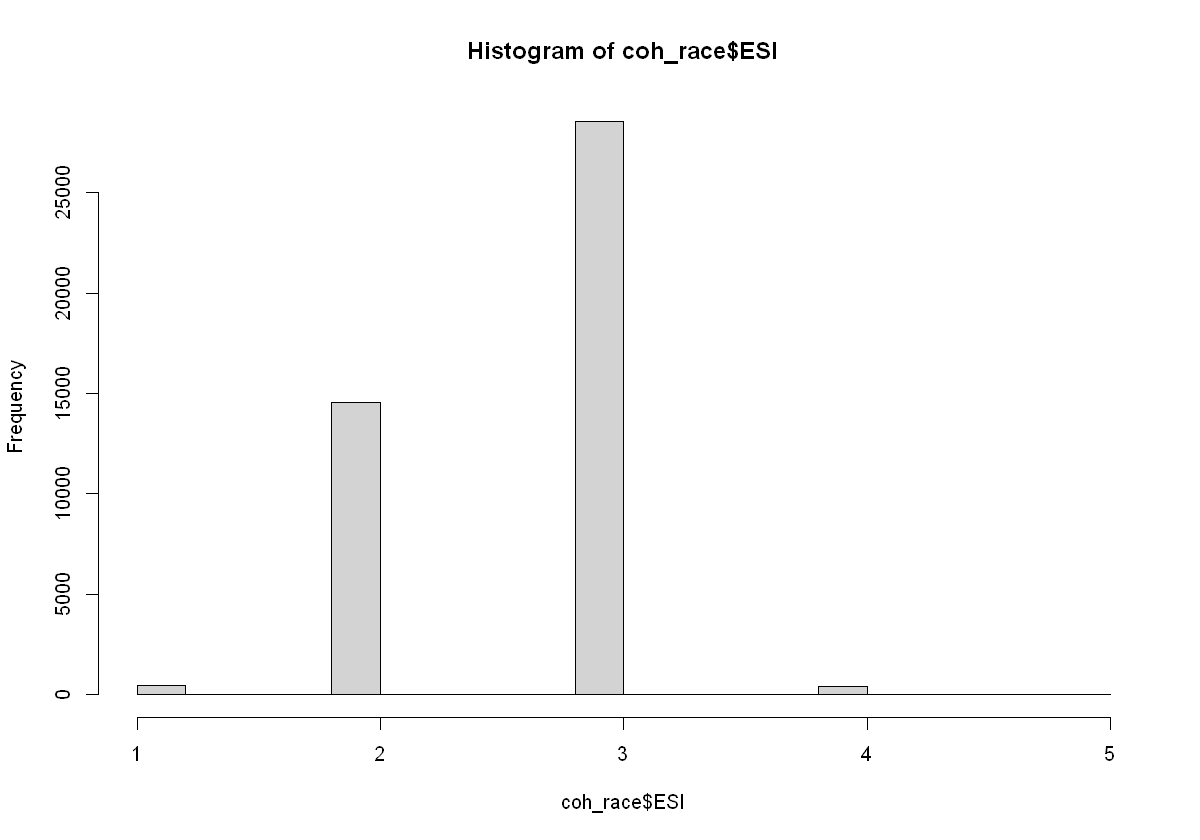

In [50]:
race <- demo %>% select(anon_id, pat_enc_csn_id_coded, race)
coh_race <- left_join(cohort, race) %>% left_join(esi) %>% mutate(race=factor(race))
nrow(coh_race)
summary(coh_race)

hist(coh_race$ESI)

In [51]:
race_esi <- coh_race %>% group_by(race, ESI) %>% summarise(n = n()) %>% 
                group_by(race) %>% mutate(ntotal = sum(n), group_percentage = round(100*n/ntotal, 2))
race_esi

`summarise()` regrouping output by 'race' (override with `.groups` argument)



race,ESI,n,ntotal,group_percentage
<fct>,<int>,<int>,<int>,<dbl>
Asian,1,69,6655,1.04
Asian,2,2307,6655,34.67
Asian,3,4224,6655,63.47
Asian,4,53,6655,0.80
Asian,5,2,6655,0.03
Black,1,43,3104,1.39
Black,2,1084,3104,34.92
Black,3,1938,3104,62.44
Black,4,36,3104,1.16


In [17]:
color_table <- tibble(
  race = c("Asian", "Black", "Native American", "Other", "Pacific Islander", "Unknown", "White"),
  color = c("tan", "grey30", "salmon4", "magenta3", "tan3", "limegreen", "moccasin")
  )
color_table5 <- tibble(
  race = c("Asian", "Black", "Other", "White"),
  color = c("tan", "grey30", "magenta3", "moccasin")
  )

race_esi1 <- race_esi %>% filter(ESI==1)
race_esi23 <- race_esi %>% filter(ESI==2 | ESI==3)
race_esi4 <- race_esi %>% filter(ESI==4)
race_esi5 <- race_esi %>% filter(ESI==5)

race_esi5

race,ESI,n,ntotal,group_percentage
<fct>,<int>,<int>,<int>,<dbl>
Asian,5,2,6655,0.03
Black,5,3,3104,0.10
Other,5,4,10170,0.04
White,5,7,22580,0.03


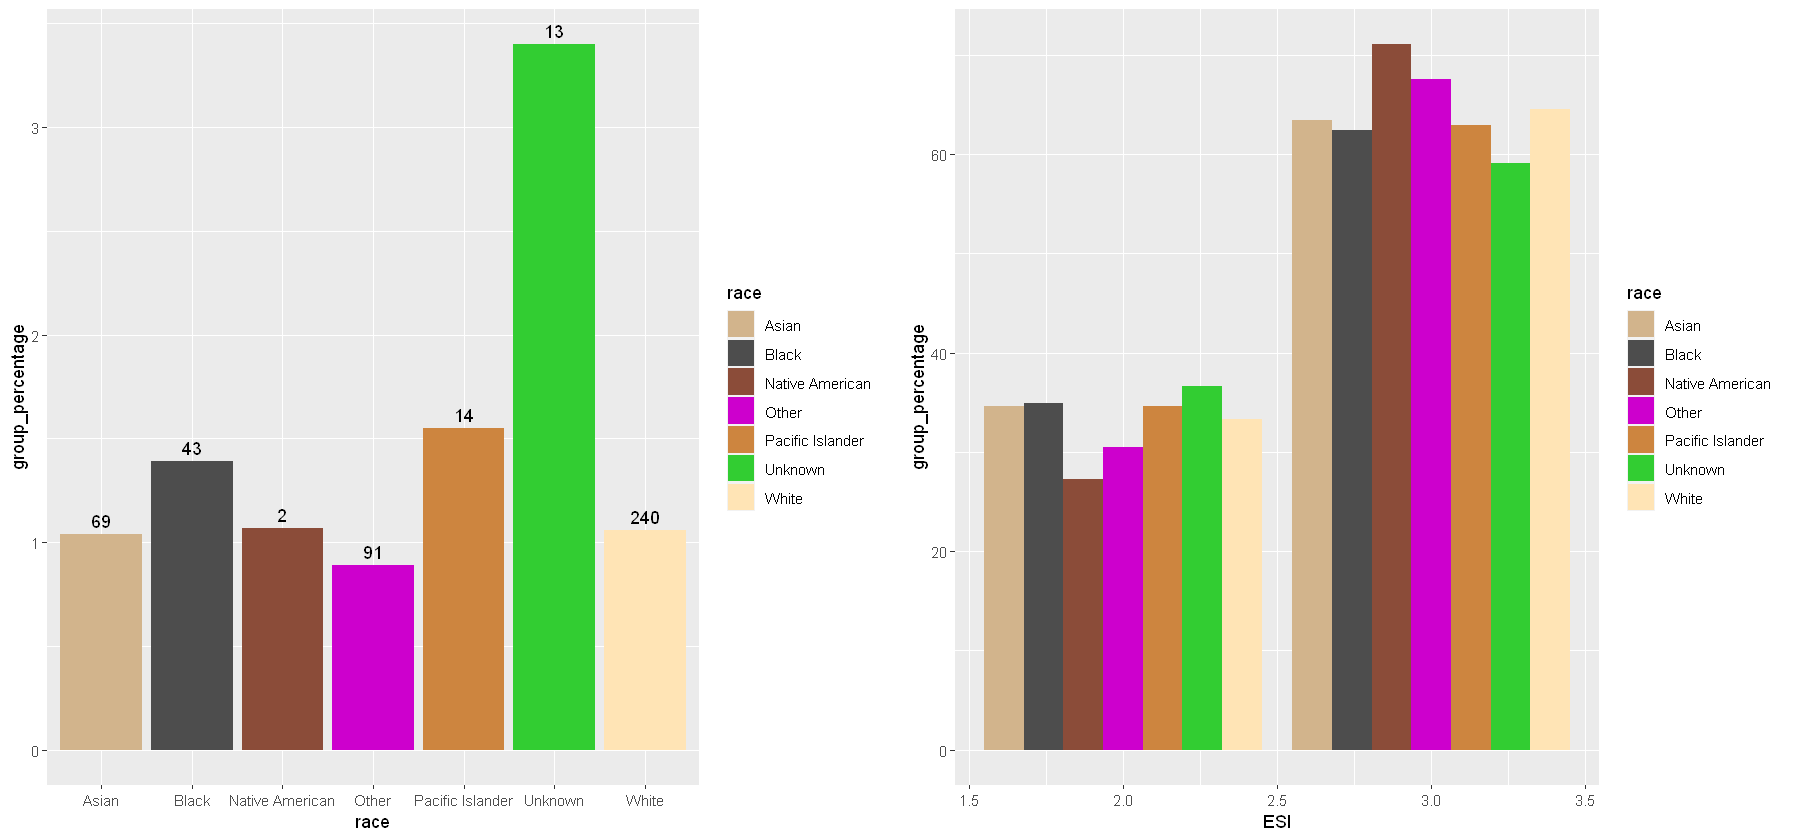

In [21]:
options(repr.plot.width=15, repr.plot.height=7)

p1 <- ggplot(race_esi1, aes(fill=race, y=group_percentage, x=race)) + 
    geom_bar(position="dodge", stat="identity") + scale_fill_manual(values = color_table$color) +
    geom_text(aes(label=n), position=position_dodge(width=1), vjust=-0.5)

p23 <- ggplot(race_esi23, aes(fill=race, y=group_percentage, x=ESI)) + 
    geom_bar(position="dodge", stat="identity") + scale_fill_manual(values = color_table$color) #+
#     geom_text(aes(label=n), position=position_dodge(width=1), vjust=0, angle=90)

grid.arrange(p1, p23, ncol=2)
ggsave(file.path(figuredir,"Fig5_ESI123.png"), width = 15, height = 7, dpi = 1200) 

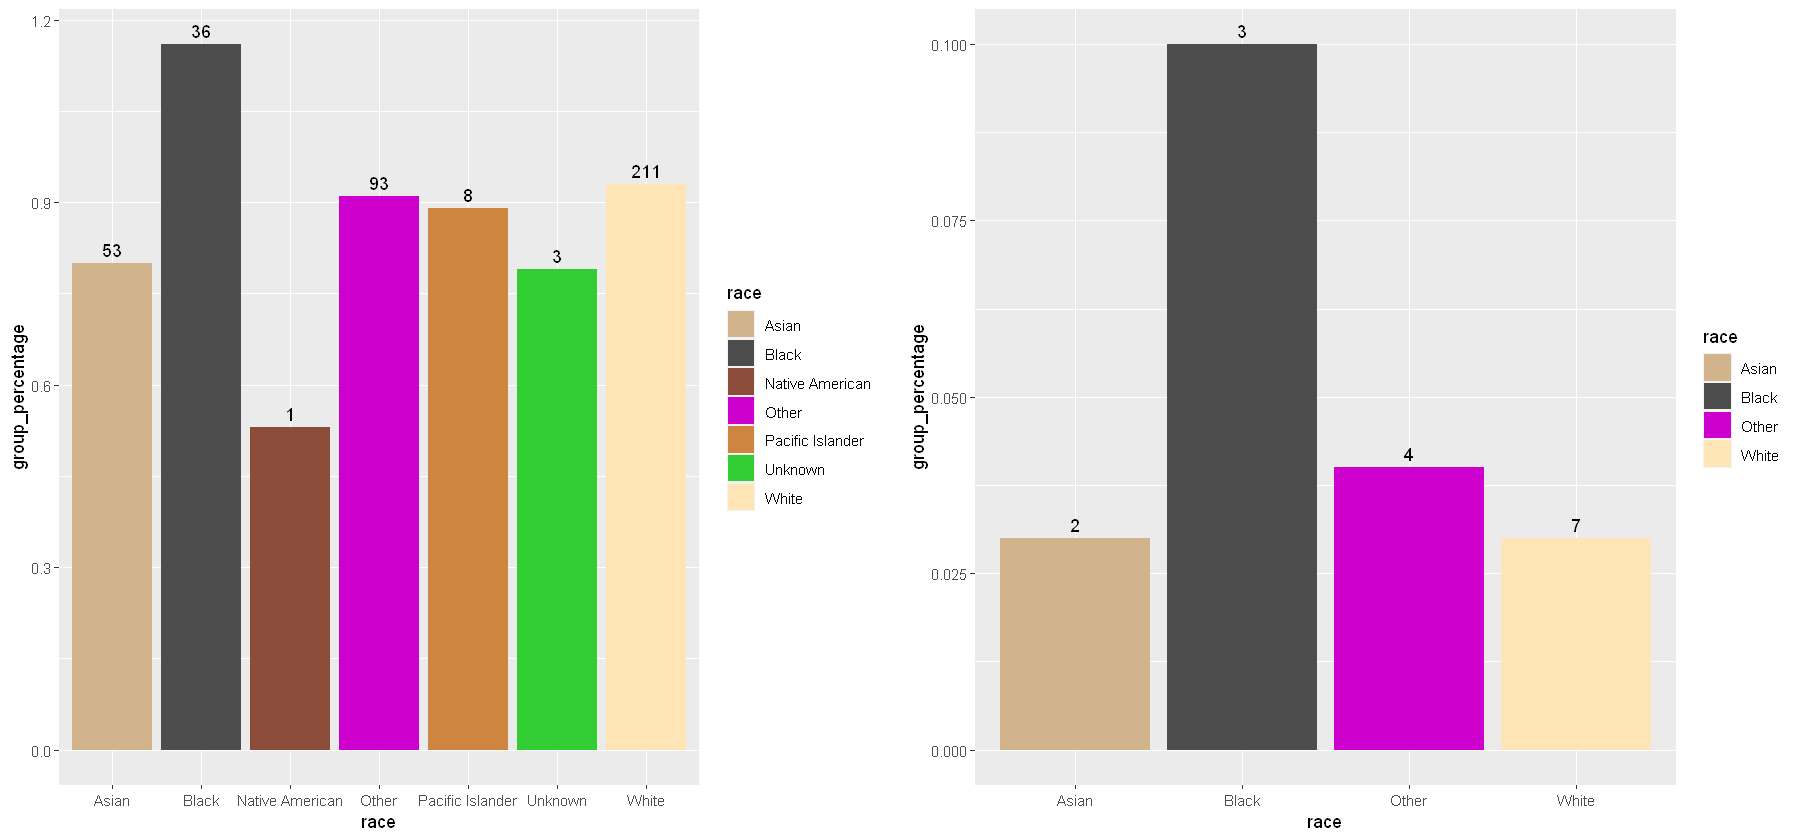

In [22]:
p4 <- ggplot(race_esi4, aes(fill=race, y=group_percentage, x=race)) + 
    geom_bar(position="dodge", stat="identity") + scale_fill_manual(values = color_table$color) +
    geom_text(aes(label=n), position=position_dodge(width=1), vjust=-0.5)

p5 <- ggplot(race_esi5, aes(fill=race, y=group_percentage, x=race)) + 
    geom_bar(position="dodge", stat="identity") + scale_fill_manual(values = color_table5$color) +
    geom_text(aes(label=n), position=position_dodge(width=1), vjust=-0.5)

grid.arrange(p4, p5, ncol=2)
# plotlist <- list(p4, p5)
# plot_grid(plotlist=plotlist)
ggsave(file.path(figuredir,"Fig5_ESI45.png"), width = 15, height = 7, dpi = 1200) 

### density plot of predicted probabilities for test cohort


In [26]:
coh_test <- read.csv(file.path(modeldir4, "1_4_cohort_test_results.csv")) %>% 
                select(pat_enc_csn_id_coded, first_label, death_24hr_max_label, death_24hr_recent_label, 
                       pred_first, pred_death_24hr_max, pred_death_24hr_recent, abs_diff0_24, transfer)
nrow(coh_test)
colnames(coh_test)
# preds_max <- coh_test %>% select(outcome = death_24hr_max_label, prediction = pred_death_24hr_max)
# preds_24hr <- coh_test %>% select(outcome = death_24hr_recent_label, prediction = pred_death_24hr_recent)

[1] 12418

[1] "pat_enc_csn_id_coded"    "first_label"            
[3] "death_24hr_max_label"    "death_24hr_recent_label"
[5] "pred_first"              "pred_death_24hr_max"    
[7] "pred_death_24hr_recent"  "abs_diff0_24"           
[9] "transfer"

In [27]:
### Plot function, using data0
plotfxn <- function(X, Xlab, Fill, data){
#     p0 <- data %>% ggplot(aes(x=X)) + geom_density() + facet_wrap(~race_recoded) # unable to use Fill here
    p1 <- data %>% ggplot(aes(x=X, fill=Fill)) +
        geom_density(alpha=0.3, position = 'identity') + # color="#e9ecef", 
        labs(fill="") + xlab(Xlab) 

    p2 <- p1 + theme(axis.text=element_text(size=14),
             axis.title=element_text(size=16), legend.key.size = unit(1, "cm"))#, face="bold"
#     return(list(p0, p2))
    return(p2)
}

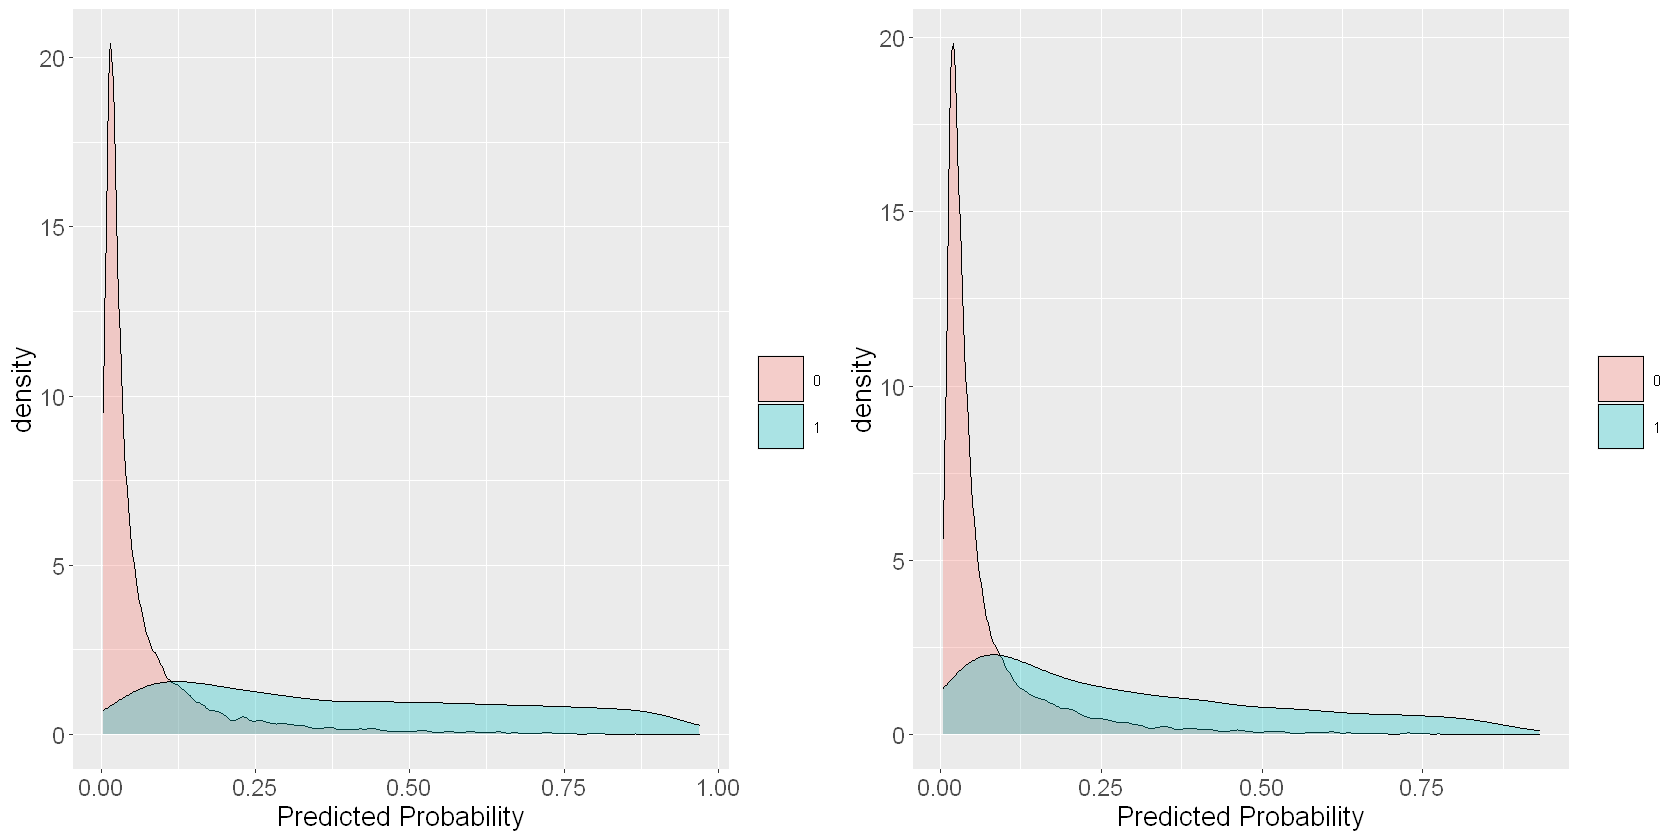

In [32]:
options(repr.plot.width=14, repr.plot.height=7)

# first label and label at 24th hr
pmax <- plotfxn(X=coh_test$pred_first, Xlab="Predicted Probability", Fill=factor(coh_test$first_label), coh_test)
p24 <- plotfxn(X=coh_test$pred_death_24hr_recent, Xlab="Predicted Probability", Fill=factor(coh_test$death_24hr_recent_label), coh_test)

grid.arrange(pmax, p24, ncol=2)
ggsave(file.path(figuredir,"Fig5_pred_density.png"), width = 14, height = 7, dpi = 1200) 

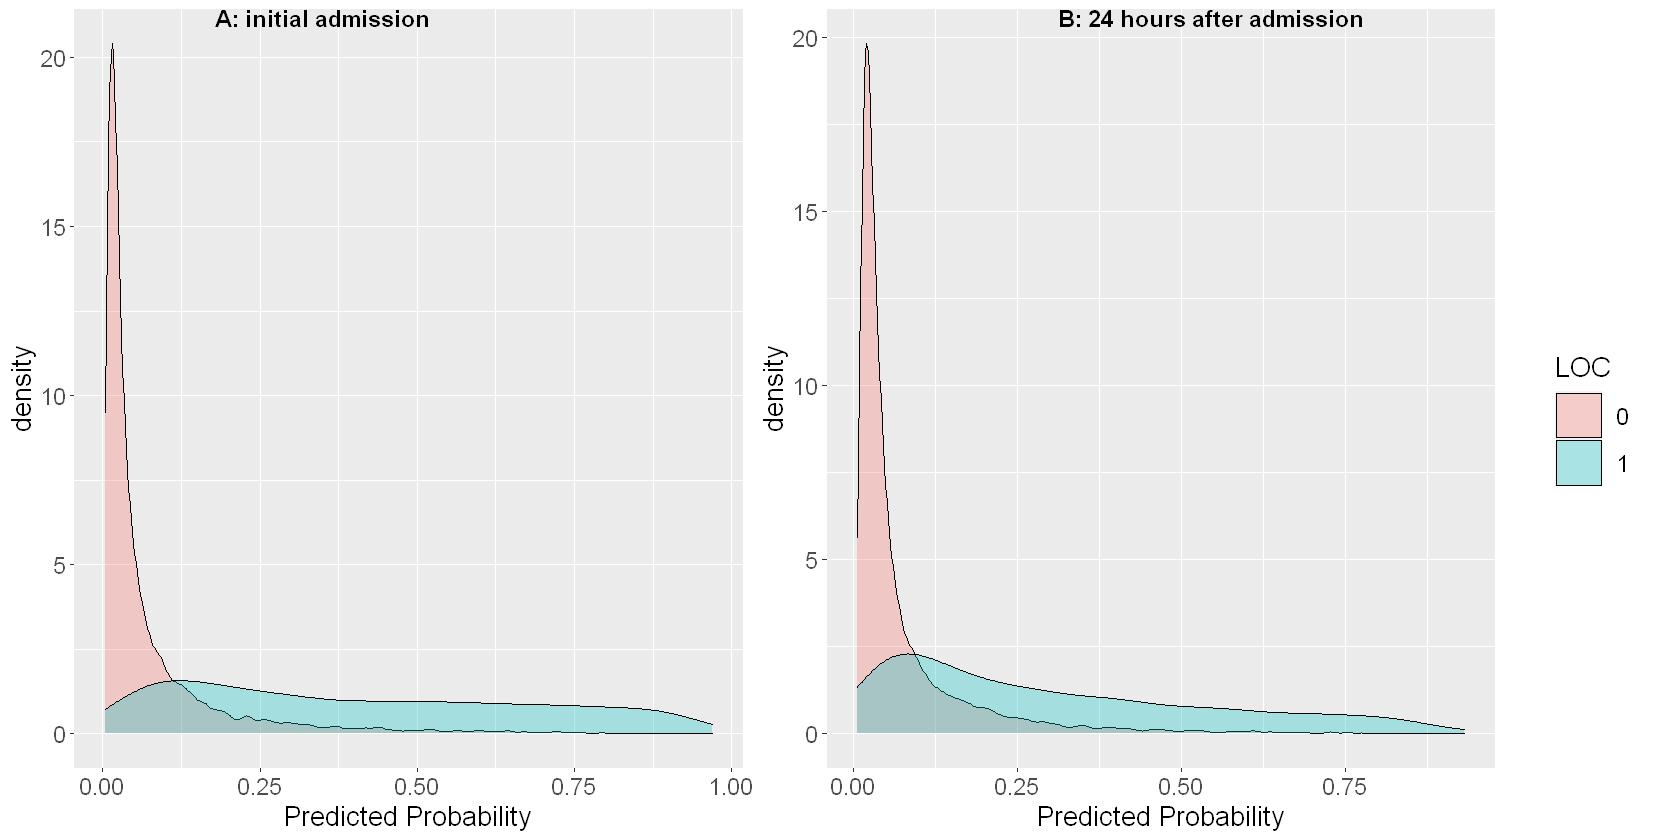

In [35]:
# at initial admission and at 24th hr, with labels, combined legends

prow <- plot_grid(
            plotfxn(X=coh_test$pred_first, Xlab="Predicted Probability", 
                    Fill=factor(coh_test$first_label), coh_test) +
                theme(legend.position="none"), 
            plotfxn(X=coh_test$pred_death_24hr_recent, Xlab="Predicted Probability", 
                    Fill=factor(coh_test$death_24hr_recent_label), coh_test) +
                theme(legend.position="none"),
            labels = c("A: initial admission", "B: 24 hours after admission"),
            hjust = -1,
            nrow = 1
)

legend <- get_legend(
            plotfxn(X=coh_test$pred_first, Xlab="Predicted Probability", 
                    Fill=factor(coh_test$first_label), coh_test) +
            theme(legend.title = element_text(color = "Black", size = 16),
                  legend.text = element_text(color = "black", size = 14)
                 ) + scale_fill_discrete(name = "LOC")#+ theme(legend.box.margin = margin(0, 0, 0, 1))
)

plot_grid(prow, legend, rel_widths=c(6, 0.7))
ggsave(file.path(figuredir,"Fig5_pred_density2.png"), width = 14, height = 7, dpi = 1200) 

In [30]:
# convert wide to long, entire test cohort
coh_test2 <- coh_test %>% rename(time0=pred_first, time24=pred_death_24hr_recent) %>% 
                select(-pred_death_24hr_max, -death_24hr_max_label)
coh_test2 <- gather(coh_test2, time, prediction, time0:time24, factor_key=TRUE)
head(coh_test2)

,pat_enc_csn_id_coded,first_label,death_24hr_recent_label,abs_diff0_24,transfer,time,prediction
,<dbl>,<int>,<int>,<dbl>,<int>,<fct>,<dbl>
1,131264906504,0,0,0.0,0,time0,0.2356759
2,131280664882,1,1,0.1,0,time0,0.9463215
3,131282861801,0,1,0.0,1,time0,0.6882317
4,131264837675,1,1,0.2,0,time0,0.6547346
5,131279238299,0,0,0.0,0,time0,0.3064106
6,131265866954,1,1,0.0,0,time0,0.7664736


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



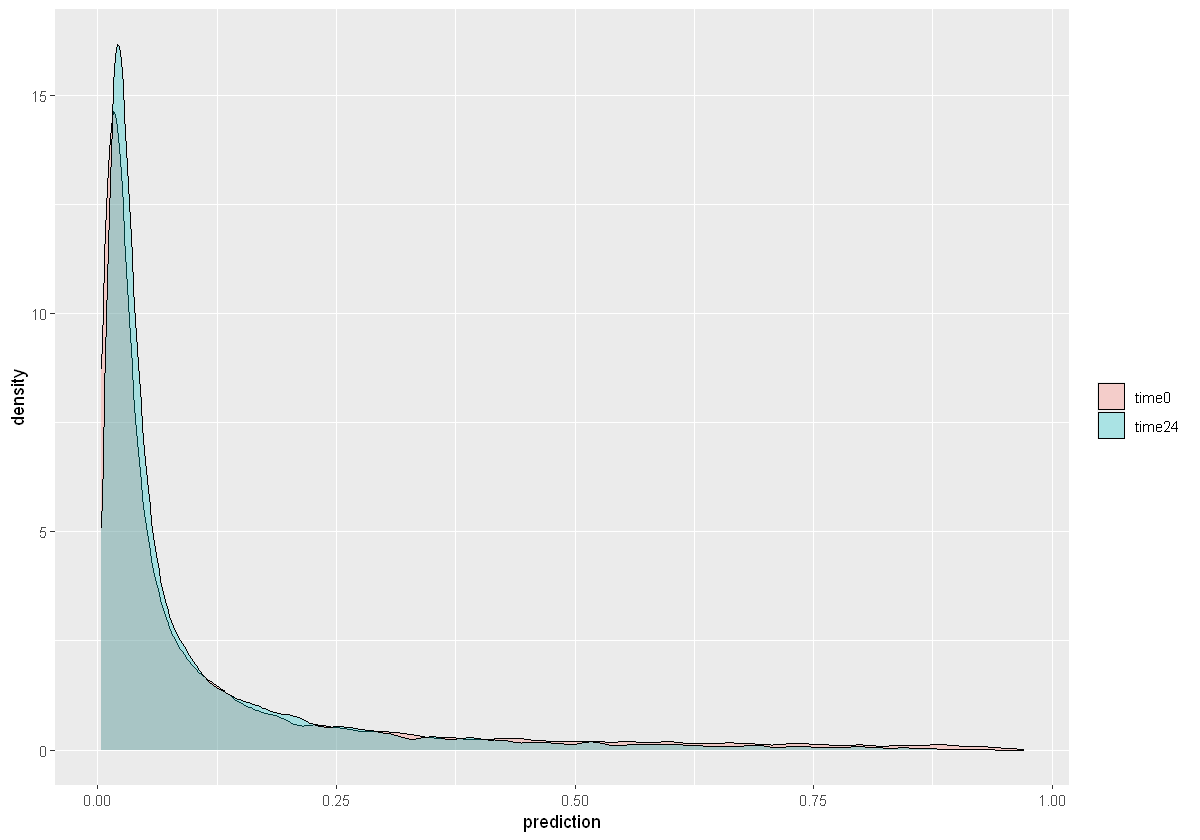

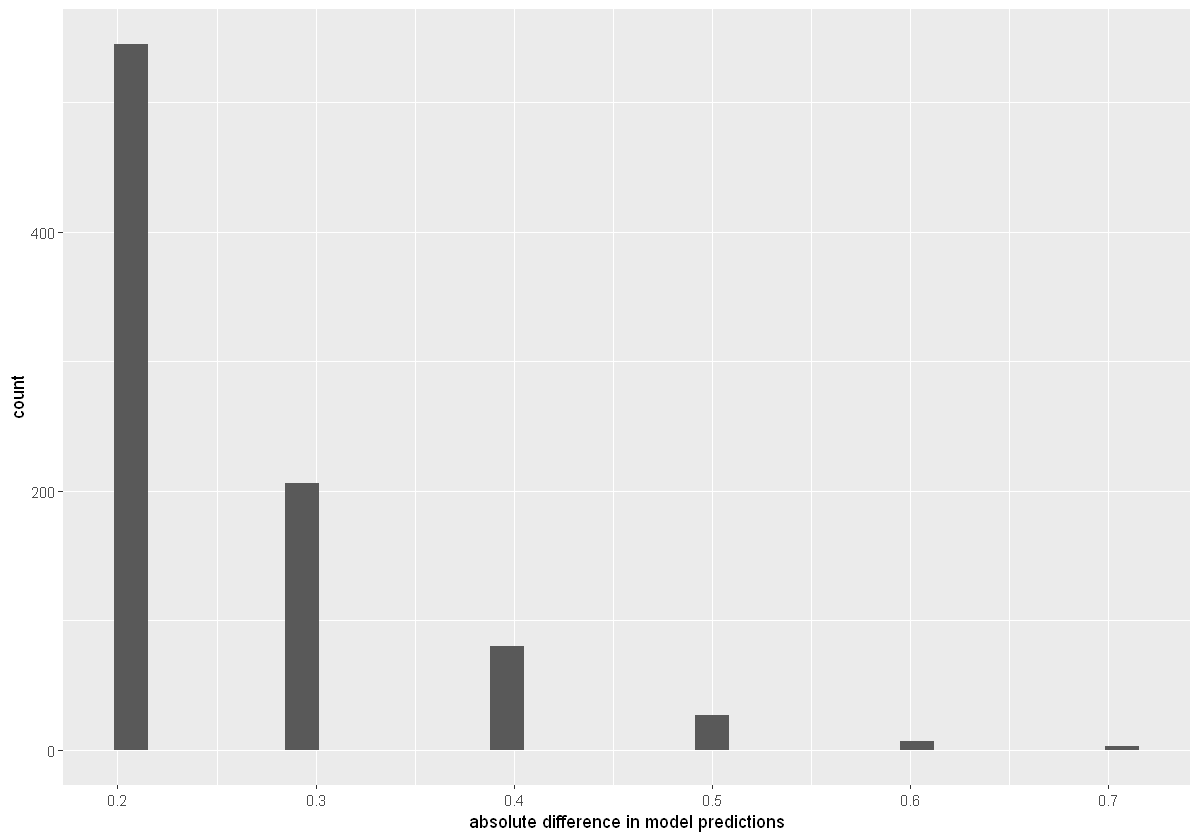

In [36]:
# hist(coh_test$abs_diff0_24)
# plotfxn(X=cohdis$pred_death_24hr_recent, Xlab="Predicted Probability", Fill=factor(coh_test$death_24hr_recent_label), coh_test)

options(repr.plot.width=10, repr.plot.height=7)

# test cohort, with abs difference btwn predicted values at time0 and time24 greater than 0.1
ggplot(data = coh_test2, aes(x=prediction, fill=time)) +
        geom_density(alpha=0.3, position = 'identity') + # color="#e9ecef", 
        labs(fill="")

ggplot(data = coh_test[coh_test$abs_diff0_24 > 0.1, ], aes(x=abs_diff0_24)) +
        geom_histogram() + xlab("absolute difference in model predictions")

In [21]:
# get discordance cohort abs_diff0_@4 >= 0.4
colnames(coh_test)
coh_dis <- coh_test %>% filter(abs_diff0_24 >= 0.4)
nrow(coh_dis)

[1] "pat_enc_csn_id_coded"    "first_label"            
[3] "death_24hr_max_label"    "death_24hr_recent_label"
[5] "pred_first"              "pred_death_24hr_max"    
[7] "pred_death_24hr_recent"  "abs_diff0_24"           
[9] "transfer"

[1] 117

In [ ]:
# coh_dis[coh_dis$transfer==1, ]$pred_first
# coh_dis[coh_dis$transfer==1 & coh_dis$first_label==1, ]$pred_first

In [22]:
# discordance cohort, only with pred at time 24, not the primary outcome, wide to long
cohdis <- coh_dis %>% rename(time0=pred_first, time24=pred_death_24hr_recent) %>% 
            select(-pred_death_24hr_max, -death_24hr_max_label)

# get an index for each of the observations 
cohdis$idx <- rownames(cohdis)
nrow(cohdis)
head(cohdis)

# wide to long
cohdis2 <- gather(cohdis, time, prediction, time0:time24, factor_key=TRUE)
nrow(cohdis2)
head(cohdis2)

[1] 117

,pat_enc_csn_id_coded,first_label,death_24hr_recent_label,time0,time24,abs_diff0_24,transfer,idx
,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<chr>
1,131274348480,0,0,0.8106468,0.4368035,0.4,0,1
2,131281383883,1,1,0.5626119,0.1700678,0.4,0,2
3,131282719671,1,1,0.7961093,0.4289658,0.4,0,3
4,131284115343,1,1,0.5984289,0.2139906,0.4,0,4
5,131281707426,1,1,0.5319339,0.1795119,0.4,0,5
6,131263212928,0,0,0.6490586,0.2920811,0.4,0,6


[1] 234

,pat_enc_csn_id_coded,first_label,death_24hr_recent_label,abs_diff0_24,transfer,idx,time,prediction
,<dbl>,<int>,<int>,<dbl>,<int>,<chr>,<fct>,<dbl>
1,131274348480,0,0,0.4,0,1,time0,0.8106468
2,131281383883,1,1,0.4,0,2,time0,0.5626119
3,131282719671,1,1,0.4,0,3,time0,0.7961093
4,131284115343,1,1,0.4,0,4,time0,0.5984289
5,131281707426,1,1,0.4,0,5,time0,0.5319339
6,131263212928,0,0,0.4,0,6,time0,0.6490586


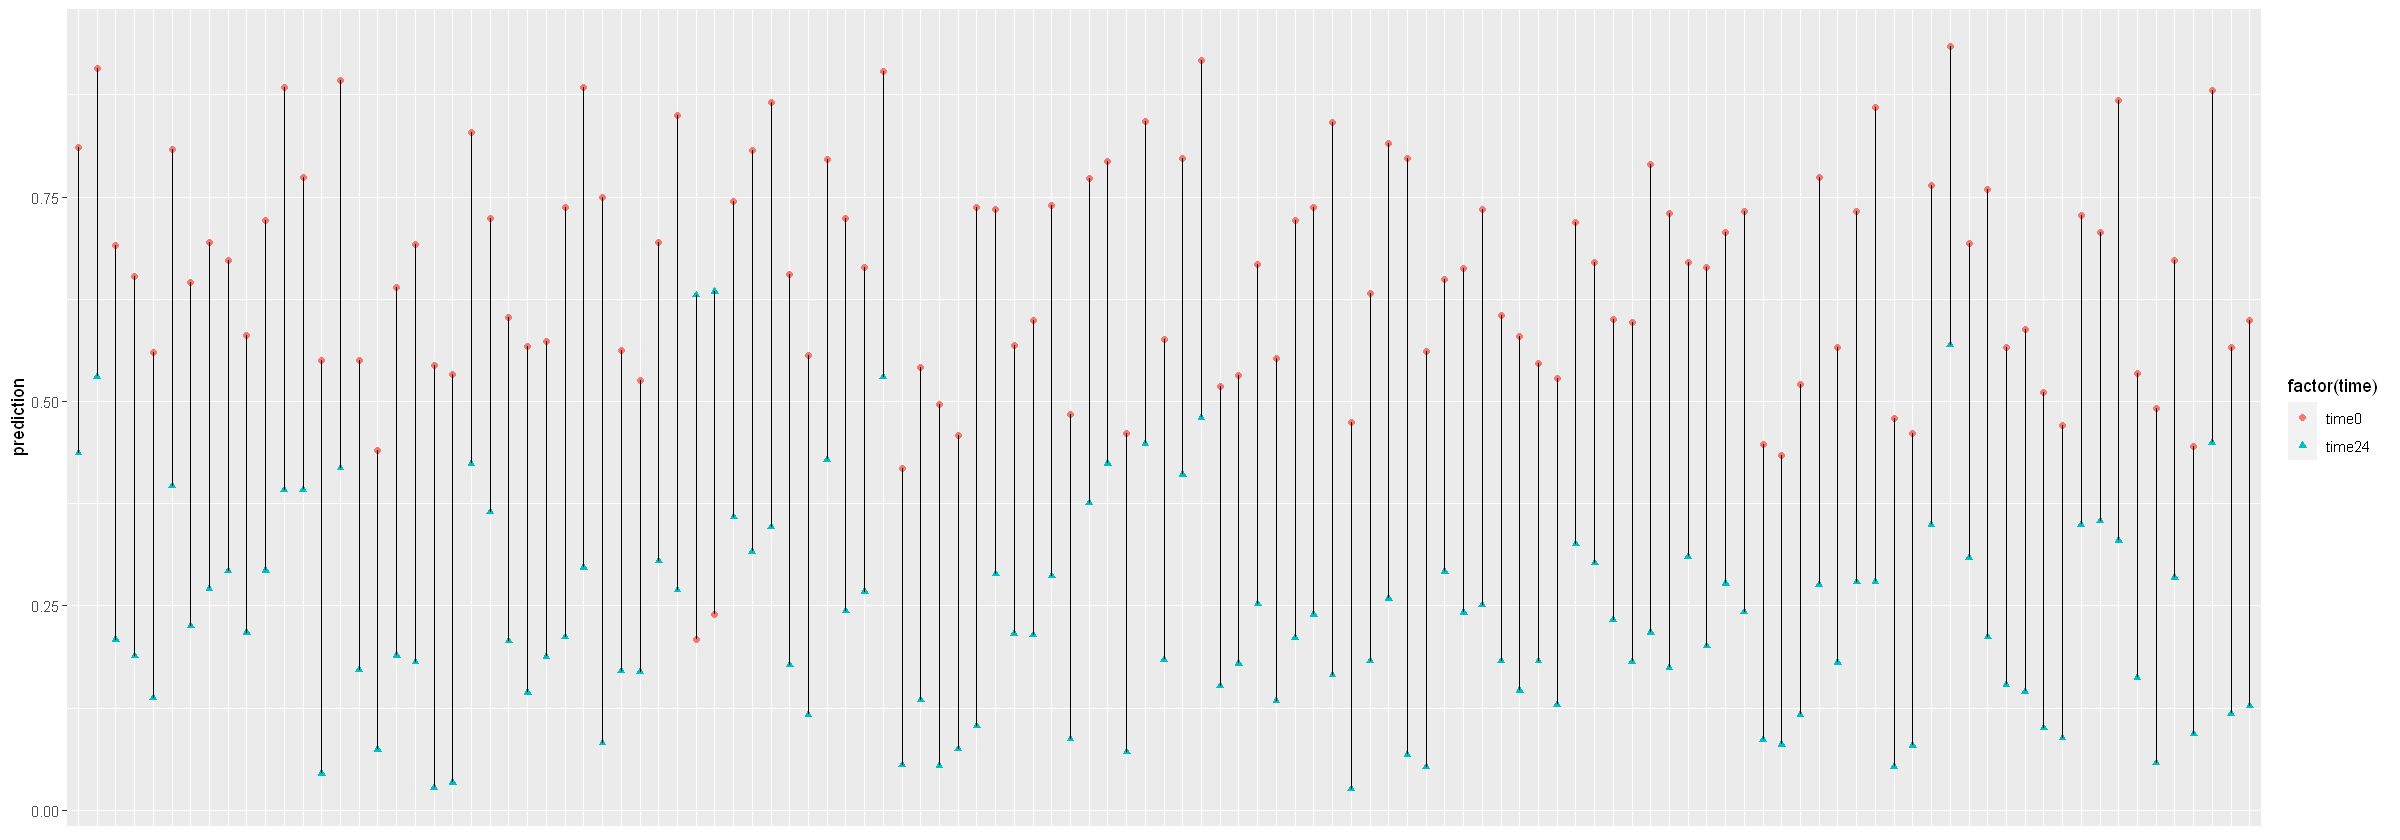

In [23]:
# all discordance >= 0.4 in pairs, not very informative
options(repr.plot.width=20, repr.plot.height=7)

p <- ggplot(cohdis2, aes(idx, prediction)) + 
        geom_point(aes(colour = factor(time), shape = factor(time))) + 
        geom_line(aes(group = idx)) +
        theme(axis.title.x=element_blank(),
              axis.text.x=element_blank(),
              axis.ticks.x=element_blank())
p

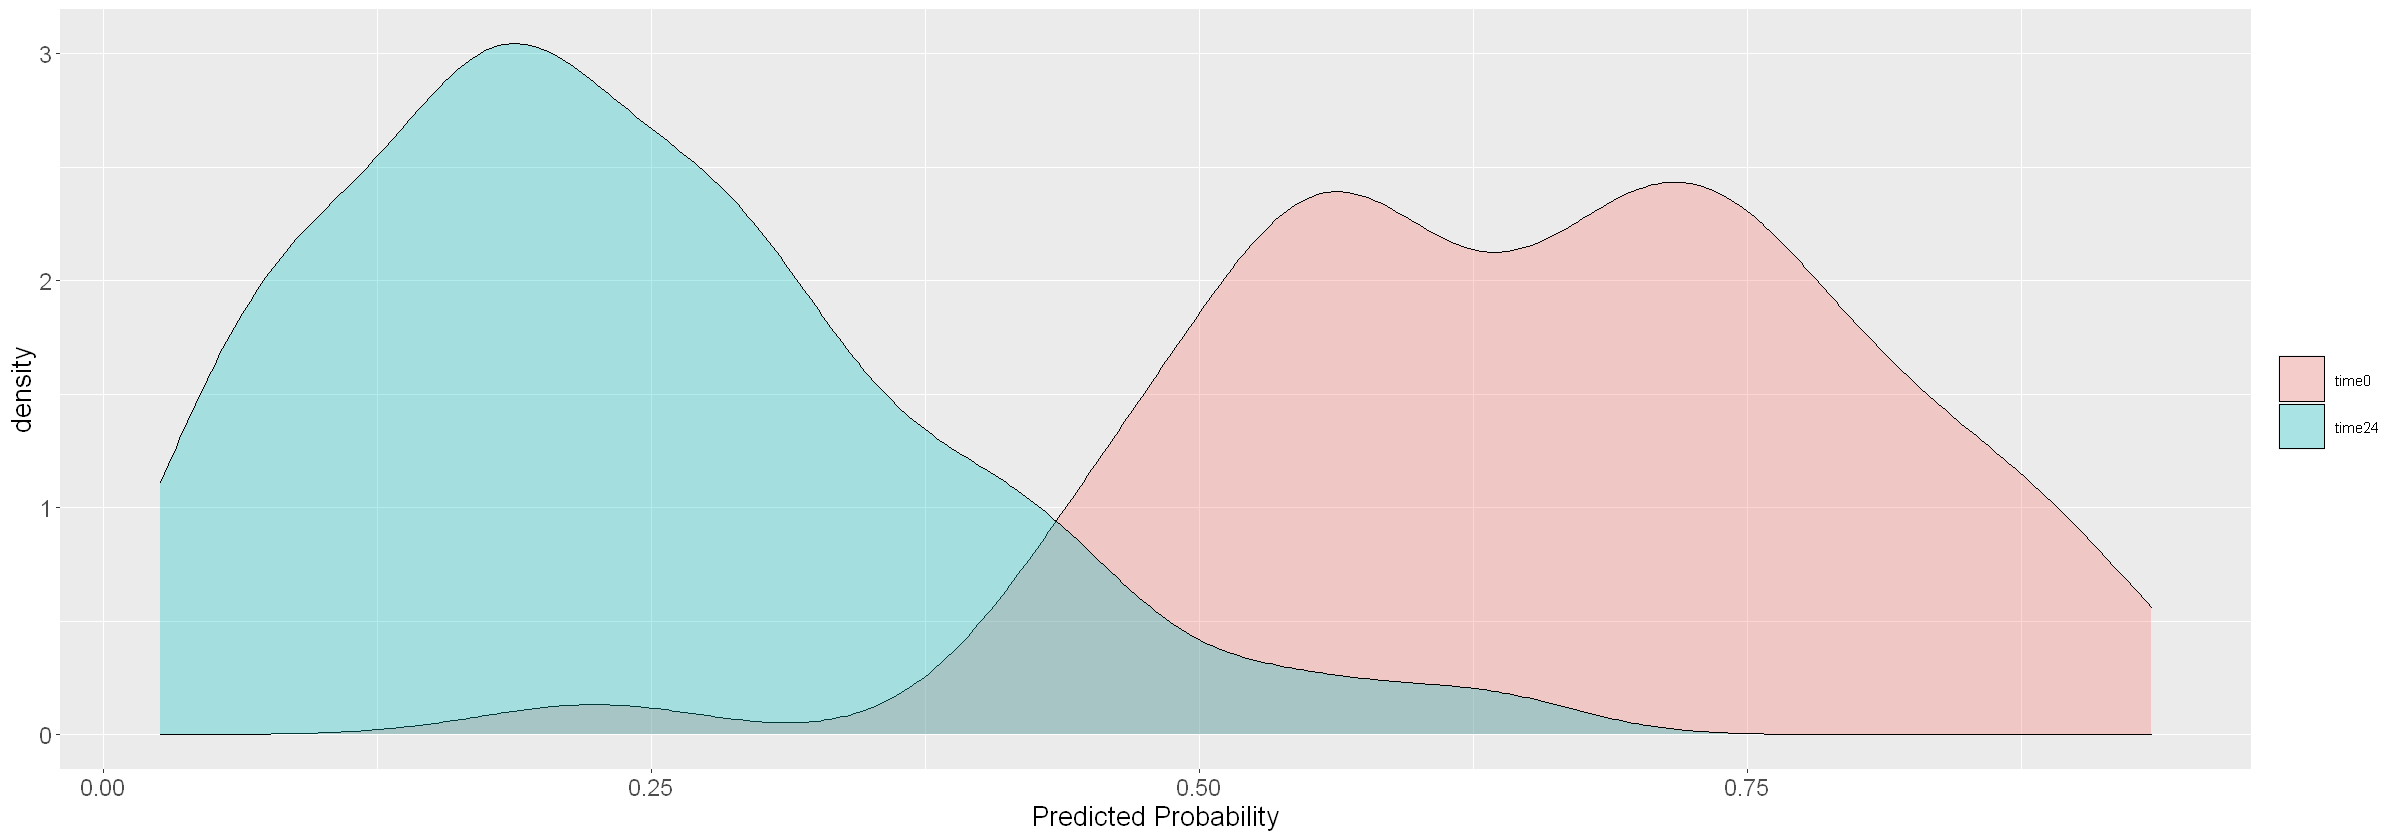

In [24]:
# density plot for prediction at time 0 and 24 for the discordance cohort
# time0 prob lean toward higher values and time24 leans toward lower values
plotfxn(X=cohdis2$prediction, Xlab="Predicted Probability", Fill=factor(cohdis2$time), cohdis2)

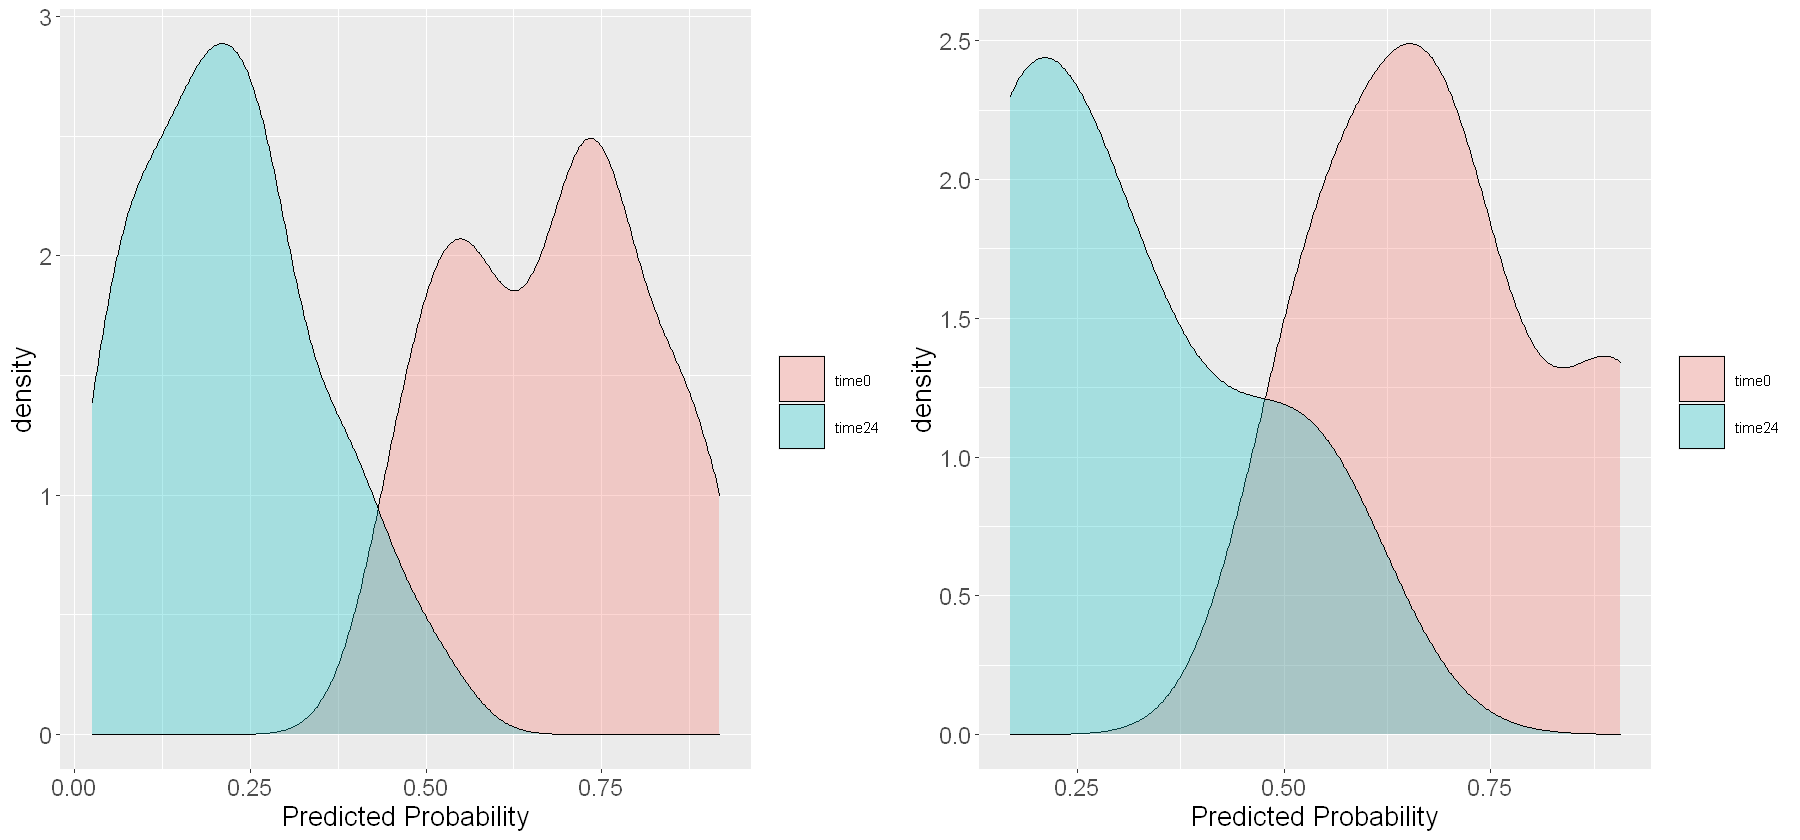

In [25]:
# coh_dis[coh_dis$transfer==1, ]$pred_first
# coh_dis[coh_dis$transfer==1 & coh_dis$first_label==1, ]$pred_first

# discordance cohort who did transfer
dtx10 = cohdis2[cohdis2$transfer==1 & cohdis2$first_label==1, ]
dtx01 = cohdis2[cohdis2$transfer==1 & cohdis2$first_label==0, ]

pdtx10 <- plotfxn(X=dtx10$prediction, Xlab="Predicted Probability", Fill=factor(dtx10$time), dtx10)
pdtx01 <- plotfxn(X=dtx01$prediction, Xlab="Predicted Probability", Fill=factor(dtx01$time), dtx01)

options(repr.plot.width=15, repr.plot.height=7)
grid.arrange(pdtx10, pdtx01, ncol=2)

# ggsave(file.path(resultdir,"Fig_disc_tx_dens.png"), width = 14, height = 7, dpi = 1200) 

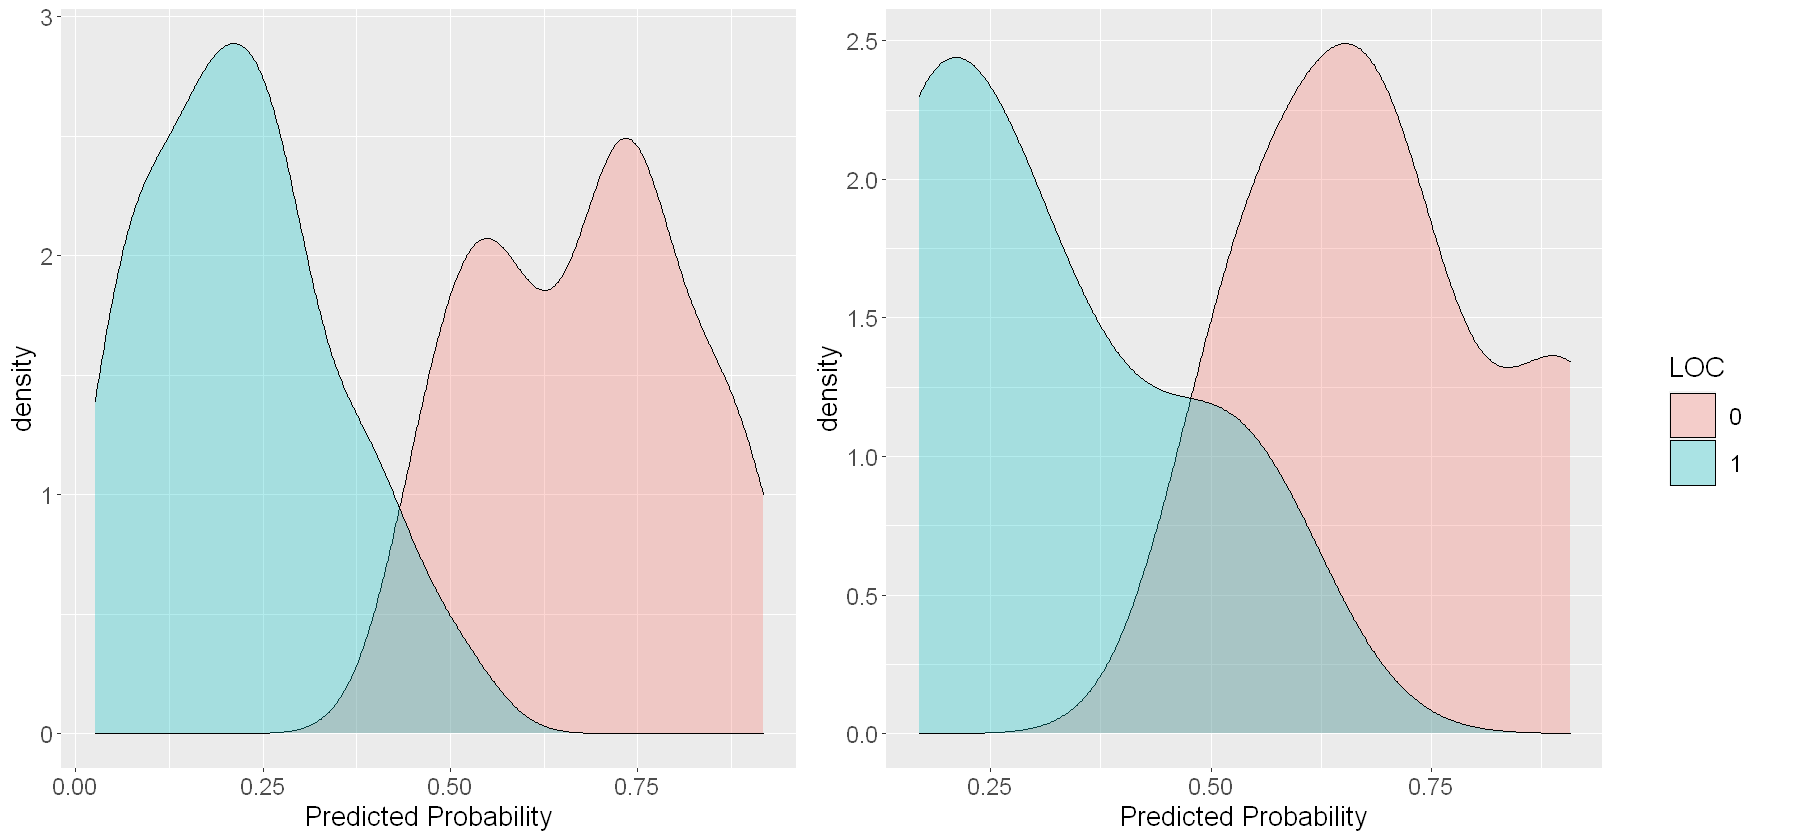

In [26]:
# remove duplicate legends

prowt <- plot_grid(pdtx10 + theme(legend.position="none"), pdtx01 + theme(legend.position="none"),
#             labels = c("A: highest LOC", "B: time24 LOC"),
            hjust = -1,
            nrow = 1
)

# legend <- get_legend(
#             plotfxn(X=coh_test$pred_death_24hr_max, Xlab="Predicted Probability", 
#                     Fill=factor(coh_test$death_24hr_max_label), coh_test) +
#             theme(legend.title = element_text(color = "Black", size = 16),
#                   legend.text = element_text(color = "black", size = 14)
#                  ) + scale_fill_discrete(name = "LOC")#+ theme(legend.box.margin = margin(0, 0, 0, 1))
# )
plot_grid(prowt, legend, rel_widths=c(6, 0.7))

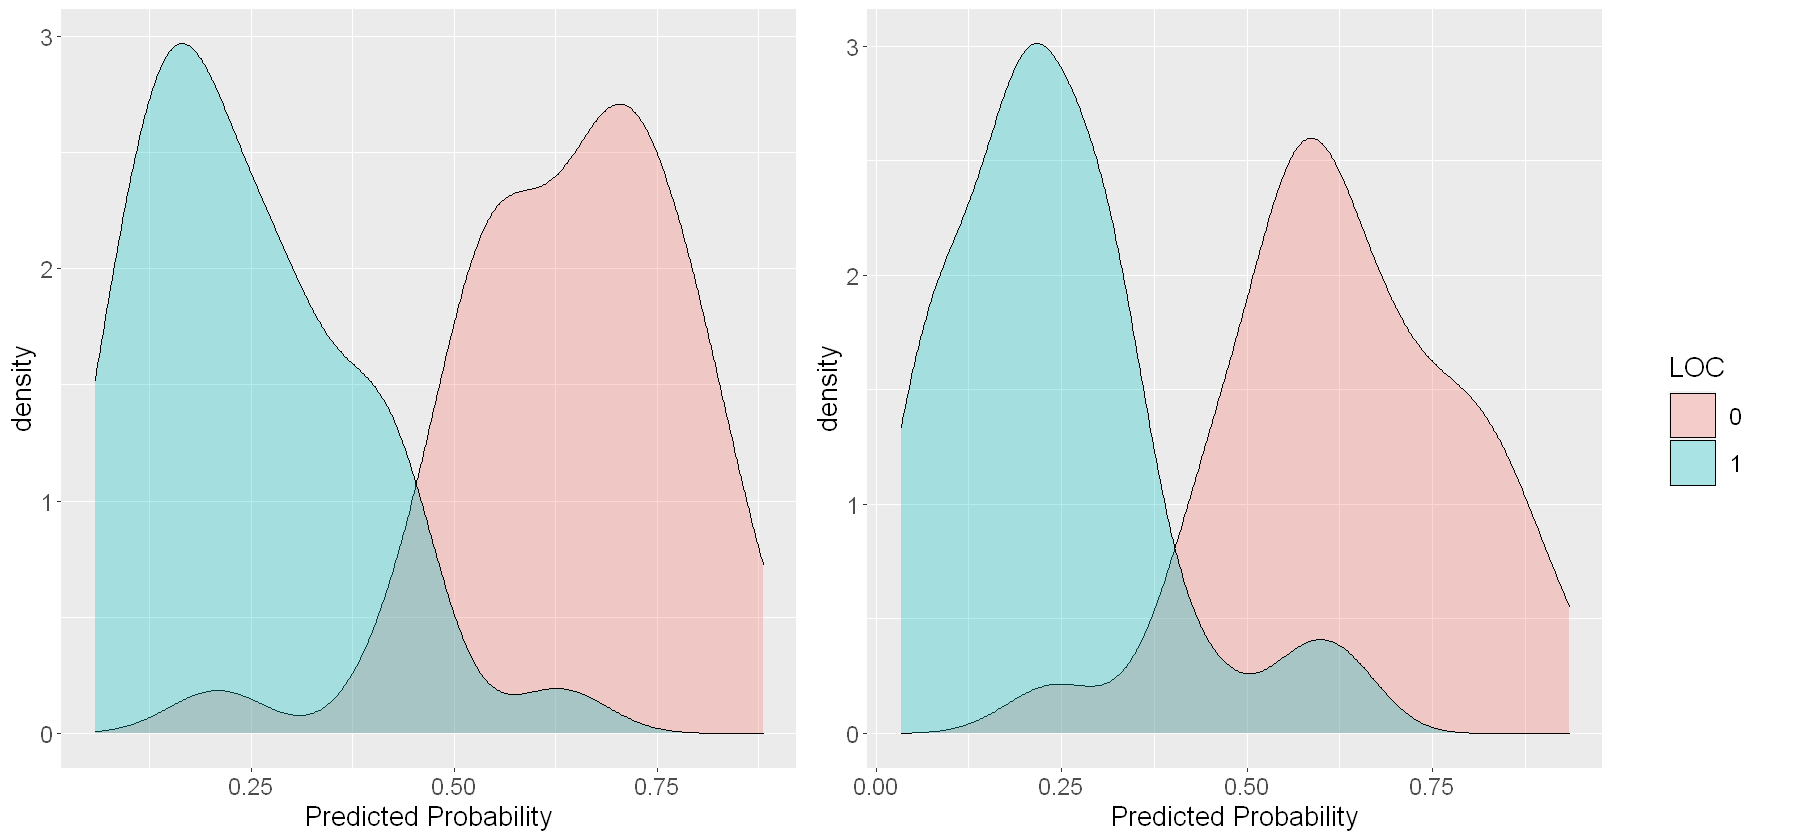

In [27]:
# discordance cohort who did not transfer
# remove duplicate legends

d1 = cohdis2[cohdis2$transfer==0 & cohdis2$first_label==1, ]
d0 = cohdis2[cohdis2$transfer==0 & cohdis2$first_label==0, ]

pd1 <- plotfxn(X=d1$prediction, Xlab="Predicted Probability", Fill=factor(d1$time), d1)
pd0 <- plotfxn(X=d0$prediction, Xlab="Predicted Probability", Fill=factor(d0$time), d0)

# plot
options(repr.plot.width=15, repr.plot.height=7)
# grid.arrange(pd1, pd0, ncol=2)

prowd <- plot_grid(pd1 + theme(legend.position="none"), pd0 + theme(legend.position="none"),
#             labels = c("A: highest LOC", "B: time24 LOC"),
            hjust = -1,
            nrow = 1
)

plot_grid(prowd, legend, rel_widths=c(6, 0.7))
# ggsave(file.path(resultdir,"Fig_disc_notx_dens.png"), width = 14, height = 7, dpi = 1200) 

### check LOS and death
This has less than the full cohort

In [28]:
los <- read_csv(file.path(resultdir, "5_2_length_of_stay_labels.csv"))
nrow(los)


-- Column specification --------------------------------------------------------
cols(
  anon_id = col_character(),
  pat_enc_csn_id_coded = col_double(),
  admit_time = col_datetime(format = ""),
  first_ED_time = col_datetime(format = ""),
  discharge_time = col_datetime(format = ""),
  end_date = col_date(format = ""),
  length_of_ip_since_admit = col_character(),
  length_from_ED_entry_until_end_date = col_character(),
  death_date_jittered = col_date(format = ""),
  discharge_date = col_date(format = ""),
  died_before_discharge = col_logical()
)




[1] 43980

In [30]:
head(los, n=1)

anon_id,pat_enc_csn_id_coded,admit_time,first_ED_time,discharge_time,end_date,length_of_ip_since_admit,length_from_ED_entry_until_end_date,death_date_jittered,discharge_date,died_before_discharge
<chr>,<dbl>,<dttm>,<dttm>,<dttm>,<date>,<chr>,<chr>,<date>,<date>,<lgl>
JCe78a06,131062667066,2015-01-02 01:01:00,2015-01-01 17:10:00,2015-01-11 23:40:00,2015-01-11,9 days,10 days,2020-01-10,2015-01-11,NA


In [31]:
table(los$died_before_discharge)
table(los$length_of_ip_since_admit)
table(los$length_from_ED_entry_until_end_date)


TRUE 
 120 


-158 days    0 days    1 days   10 days  101 days  104 days  106 days  109 days 
        1      1493      5897       940         1         2         1         1 
  11 days  110 days  119 days   12 days  120 days   13 days  130 days  136 days 
      757         1         1       615         1       539         1         1 
  14 days  141 days  145 days  147 days   15 days  150 days  152 days   16 days 
      446         1         1         1       367         1         1       317 
 160 days  168 days   17 days   18 days   19 days  190 days    2 days   20 days 
        1         1       265       222       184         1      7406       159 
 205 days   21 days  214 days   22 days   23 days  232 days   24 days   25 days 
        1       149         1       123       144         1       104       102 
  26 days   27 days   28 days   29 days    3 days   30 days   31 days   32 days 
       96        84        82        68      6539        67        63        50 
  33 days   34 days   35 da


-157 days    0 days    1 days   10 days  100 days  101 days  104 days  106 days 
        1       897      4611       969         1         1         1         2 
 109 days   11 days  110 days  119 days   12 days  121 days   13 days  130 days 
        1       842         1         1       652         1       562         1 
 136 days   14 days  141 days  146 days  147 days   15 days  150 days  152 days 
        1       475         1         1         1       394         1         1 
  16 days  160 days  169 days   17 days   18 days   19 days  191 days    2 days 
      317         1         1       291       235       201         1      7233 
  20 days  205 days   21 days  214 days   22 days   23 days  232 days   24 days 
      169         1       146         1       132       132         1       113 
  25 days   26 days   27 days   28 days   29 days    3 days   30 days   31 days 
      109        96        97        82        68      6917        61        73 
  32 days   33 days   34 da

In [32]:
los <- los %>% mutate(died_before_discharge = ifelse(died_before_discharge, 1, 0),
                      death_dc_days = death_date_jittered - discharge_date,
                      admit_ed_hours = round(as.numeric(difftime(admit_time, first_ED_time, units="hours")), 1),
#                       length_of_ip_since_admit = str_sub(length_of_ip_since_admit, star=1, end=-5), 
#                       length_from_ED_entry_until_end_date = str_sub(length_from_ED_entry_until_end_date, star=1, end=-5))
                      length_of_ip_since_admit= ifelse(length_of_ip_since_admit == "", NA,
                                                       as.numeric(str_sub(length_of_ip_since_admit, star=1, end=-5))),
                      length_from_ED_entry_until_end_date= ifelse(length_from_ED_entry_until_end_date == "", NA,
                                                                  as.numeric(str_sub(length_from_ED_entry_until_end_date, star=1, end=-5))))
head(los, n=1)

anon_id,pat_enc_csn_id_coded,admit_time,first_ED_time,discharge_time,end_date,length_of_ip_since_admit,length_from_ED_entry_until_end_date,death_date_jittered,discharge_date,died_before_discharge,death_dc_days,admit_ed_hours
<chr>,<dbl>,<dttm>,<dttm>,<dttm>,<date>,<dbl>,<dbl>,<date>,<date>,<dbl>,<drtn>,<dbl>
JCe78a06,131062667066,2015-01-02 01:01:00,2015-01-01 17:10:00,2015-01-11 23:40:00,2015-01-11,9,10,2020-01-10,2015-01-11,NA,1825 days,7.8


In [33]:
los <- los %>% mutate(death_dc_days = as.numeric(death_dc_days))
head(los)

anon_id,pat_enc_csn_id_coded,admit_time,first_ED_time,discharge_time,end_date,length_of_ip_since_admit,length_from_ED_entry_until_end_date,death_date_jittered,discharge_date,died_before_discharge,death_dc_days,admit_ed_hours
<chr>,<dbl>,<dttm>,<dttm>,<dttm>,<date>,<dbl>,<dbl>,<date>,<date>,<dbl>,<dbl>,<dbl>
JCe78a06,131062667066,2015-01-02 01:01:00,2015-01-01 17:10:00,2015-01-11 23:40:00,2015-01-11,9,10,2020-01-10,2015-01-11,NA,1825,7.8
JCd1c19e,131062745090,2015-01-03 05:53:00,2015-01-03 01:56:00,2015-01-07 02:00:00,2015-01-07,4,4,NA,2015-01-07,NA,NA,4.0
JCd91eb2,131062747648,2015-01-01 08:24:00,2015-01-01 01:10:00,2015-01-06 03:19:00,2015-01-06,5,5,2019-01-01,2015-01-06,NA,1456,7.2
JCe7cb4d,131062788358,2015-01-01 23:39:00,2015-01-01 17:07:00,2015-01-22 01:25:00,2015-01-22,21,21,NA,2015-01-22,NA,NA,6.5
JCe293de,131063044001,2015-01-05 02:23:00,2015-01-04 18:13:00,2015-01-05 22:30:00,2015-01-05,0,1,NA,2015-01-05,NA,NA,8.2
JCe8d756,131063080858,2015-01-07 04:00:00,2015-01-06 22:24:00,2015-01-09 21:00:00,2015-01-09,2,3,NA,2015-01-09,NA,NA,5.6


In [34]:
table(los$died_before_discharge)
summary(los$length_of_ip_since_admit)
summary(los$length_from_ED_entry_until_end_date)
summary(los[los$died_before_discharge == 1, ]$death_dc_days)


  1 
120 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
-158.000    2.000    4.000    5.855    7.000  232.000      198 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
-157.000    2.000    4.000    6.143    7.000  232.000      198 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
-160.00   -1.00   -1.00   -2.33   -1.00   -1.00   43860 

In [35]:
los %>% filter(death_dc_days < -1)
los %>% filter(length_of_ip_since_admit < 0)
los %>% filter(length_from_ED_entry_until_end_date < 0)

anon_id,pat_enc_csn_id_coded,admit_time,first_ED_time,discharge_time,end_date,length_of_ip_since_admit,length_from_ED_entry_until_end_date,death_date_jittered,discharge_date,died_before_discharge,death_dc_days,admit_ed_hours
<chr>,<dbl>,<dttm>,<dttm>,<dttm>,<date>,<dbl>,<dbl>,<date>,<date>,<dbl>,<dbl>,<dbl>
JCe83587,131267837304,2019-06-08 06:06:00,2019-06-07 21:23:00,2019-06-10 21:13:00,2019-01-01,-158,-157,2019-01-01,2019-06-10,1,-160,8.7


anon_id,pat_enc_csn_id_coded,admit_time,first_ED_time,discharge_time,end_date,length_of_ip_since_admit,length_from_ED_entry_until_end_date,death_date_jittered,discharge_date,died_before_discharge,death_dc_days,admit_ed_hours
<chr>,<dbl>,<dttm>,<dttm>,<dttm>,<date>,<dbl>,<dbl>,<date>,<date>,<dbl>,<dbl>,<dbl>
JCe83587,131267837304,2019-06-08 06:06:00,2019-06-07 21:23:00,2019-06-10 21:13:00,2019-01-01,-158,-157,2019-01-01,2019-06-10,1,-160,8.7


anon_id,pat_enc_csn_id_coded,admit_time,first_ED_time,discharge_time,end_date,length_of_ip_since_admit,length_from_ED_entry_until_end_date,death_date_jittered,discharge_date,died_before_discharge,death_dc_days,admit_ed_hours
<chr>,<dbl>,<dttm>,<dttm>,<dttm>,<date>,<dbl>,<dbl>,<date>,<date>,<dbl>,<dbl>,<dbl>
JCe83587,131267837304,2019-06-08 06:06:00,2019-06-07 21:23:00,2019-06-10 21:13:00,2019-01-01,-158,-157,2019-01-01,2019-06-10,1,-160,8.7


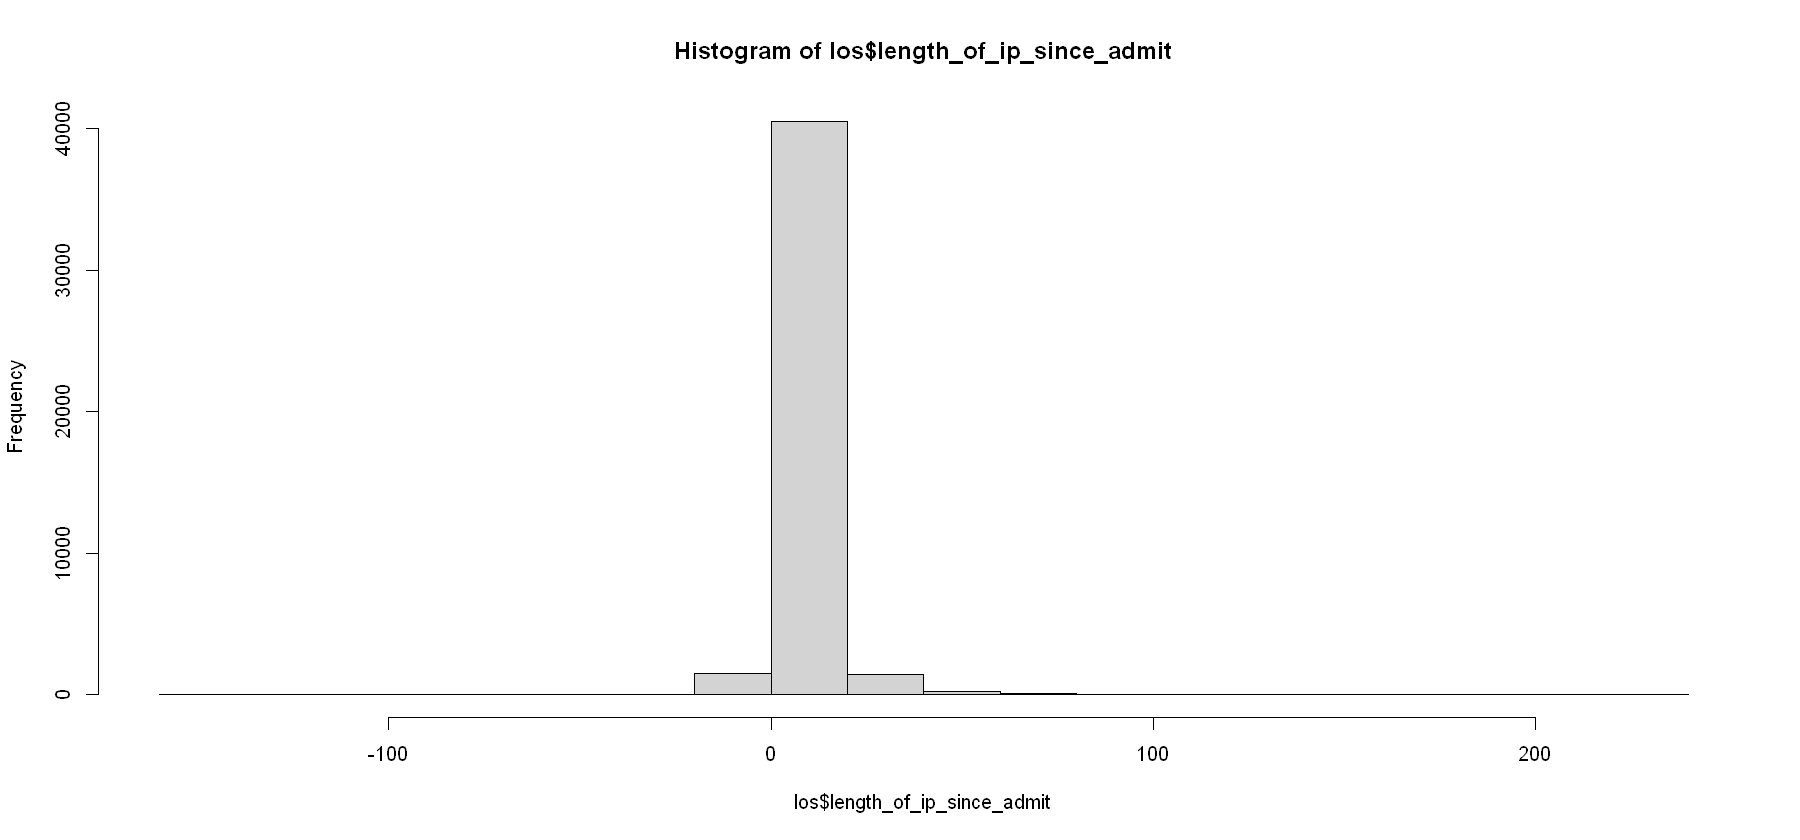

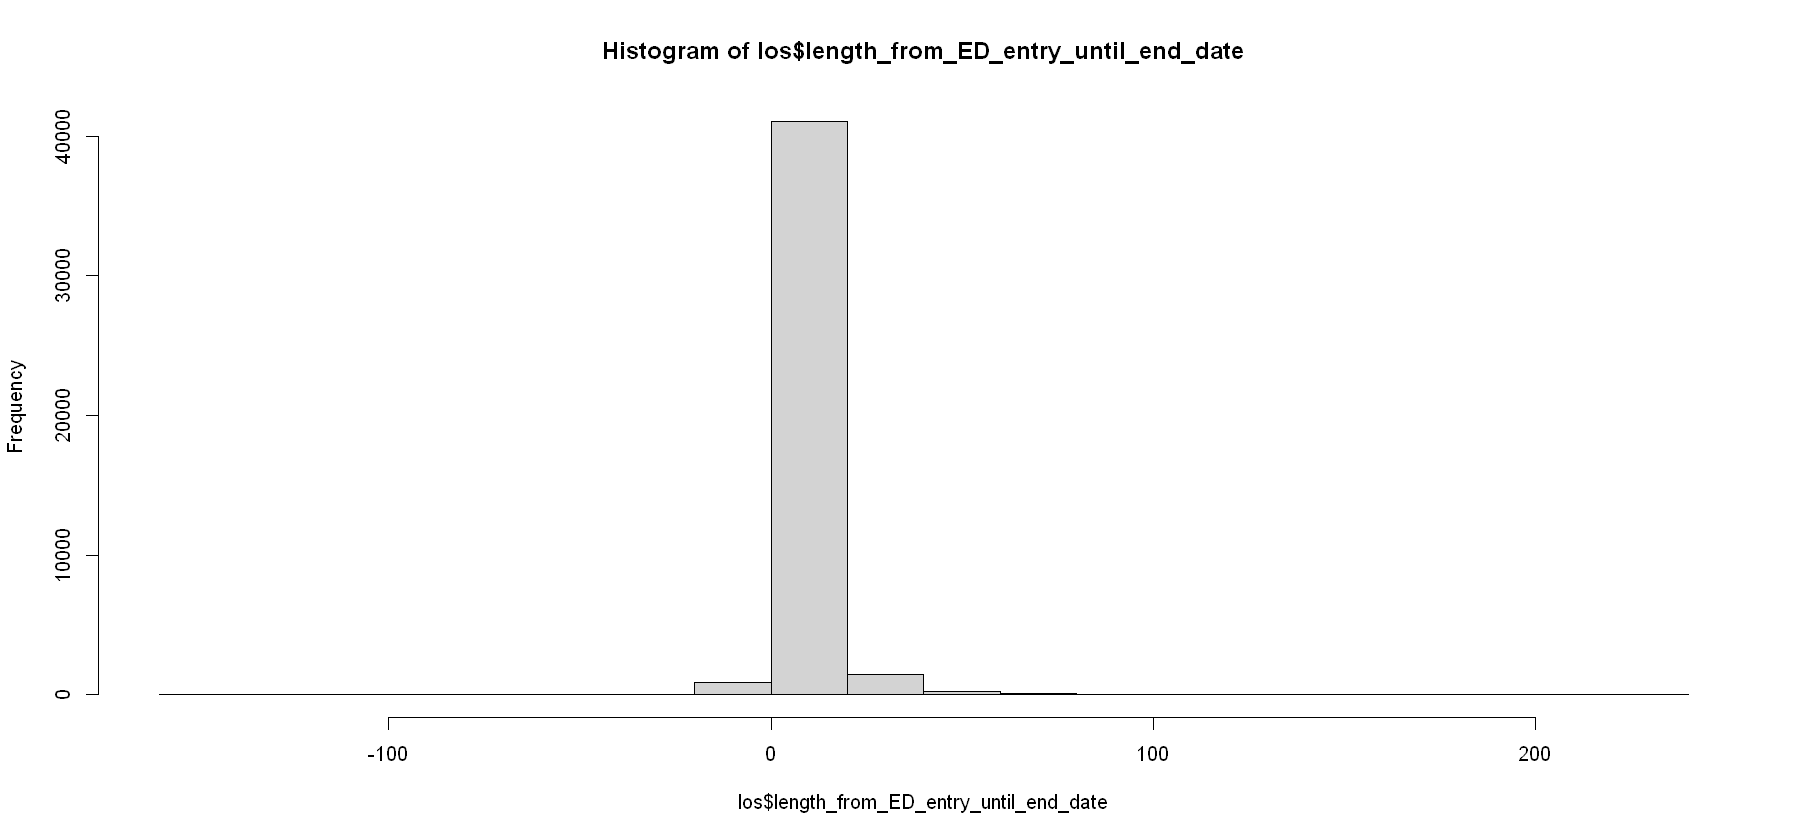

In [36]:
hist(los$length_of_ip_since_admit)
hist(los$length_from_ED_entry_until_end_date)

### read the discordance

In [37]:
los_dis <- read_csv(file.path(tabledir, "4_2_diffIDs_117.csv")) 
nrow(los_dis)


-- Column specification --------------------------------------------------------
cols(
  anon_id = col_character(),
  jitter = col_character(),
  pat_enc_csn_id_coded = col_double(),
  admit_time = col_datetime(format = ""),
  first_label = col_double(),
  death_24hr_recent_label = col_double(),
  pred_first = col_double(),
  pred_death_24hr_recent = col_double(),
  abs_diff0_24 = col_double(),
  transfer = col_double()
)




[1] 117

In [38]:
los_tx <- cohort %>% select(pat_enc_csn_id_coded, first_label, death_24hr_recent_label) %>% 
            filter(first_label != death_24hr_recent_label) %>% left_join(los)
nrow(los_tx)

Joining, by = "pat_enc_csn_id_coded"



[1] 2499

In [39]:
los_dis <- right_join(los, los_dis)
nrow(los_dis)
head(los_dis)

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "admit_time")



[1] 117

anon_id,pat_enc_csn_id_coded,admit_time,first_ED_time,discharge_time,end_date,length_of_ip_since_admit,length_from_ED_entry_until_end_date,death_date_jittered,discharge_date,died_before_discharge,death_dc_days,admit_ed_hours,jitter,first_label,death_24hr_recent_label,pred_first,pred_death_24hr_recent,abs_diff0_24,transfer
<chr>,<dbl>,<dttm>,<dttm>,<dttm>,<date>,<dbl>,<dbl>,<date>,<date>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
JCcf7ee2,131261541119,2019-01-15 06:59:00,2019-01-15 03:44:00,2019-01-16 01:00:00,2019-01-16,1,1,NA,2019-01-16,NA,NA,3.2,18 days 00:00:00.000000000,1,0,0.8834838,0.39151948,0.5,1
JCcc6f5a,131261651290,2019-01-27 21:31:00,2019-01-27 17:29:00,2019-01-29 22:00:00,2019-01-29,2,2,NA,2019-01-29,NA,NA,4.0,25 days 00:00:00.000000000,1,0,0.7241807,0.24340748,0.5,1
JCde7c64,131261808962,2019-01-16 00:57:00,2019-01-15 20:24:00,2019-01-18 22:00:00,2019-01-18,2,3,NA,2019-01-18,NA,NA,4.6,10 days 00:00:00.000000000,1,0,0.4796851,0.05314808,0.4,1
JCdd7007,131262475284,2019-02-08 03:16:00,2019-02-07 19:04:00,2019-02-12 03:23:00,2019-02-12,4,5,NA,2019-02-12,NA,NA,8.2,19 days 00:00:00.000000000,0,0,0.4612504,0.07889768,0.4,0
JCdc5d49,131262480872,2019-01-05 17:04:00,2019-01-05 15:08:00,2019-01-08 02:45:00,2019-01-08,3,3,NA,2019-01-08,NA,NA,1.9,-15 days +00:00:00.000000000,1,1,0.6639243,0.20044141,0.5,0
JCe03bac,131262690581,2019-01-13 07:44:00,2019-01-13 04:42:00,2019-01-20 00:30:00,2019-01-20,7,7,2019-04-19,2019-01-20,NA,89,3.0,-12 days +00:00:00.000000000,1,1,0.6941944,0.27086723,0.4,0


In [40]:
table(los$died_before_discharge)
table(los_dis$died_before_discharge)
table(los_tx$died_before_discharge)

summary(los$length_of_ip_since_admit)
summary(los_dis$length_of_ip_since_admit)
summary(los_tx$length_of_ip_since_admit)

summary(los$admit_ed_hours)
summary(los_dis$admit_ed_hours)
summary(los_tx$admit_ed_hours)


  1 
120 


1 
2 


 1 
25 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
-158.000    2.000    4.000    5.855    7.000  232.000      198 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   2.000   3.000   3.983   5.000  29.000 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
-158.000    2.000    4.000    6.233    7.000  160.000       15 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   2.200   3.500   4.865   5.300 190.400 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.800   2.300   3.000   3.562   4.400  10.100 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   2.100   3.000   3.652   4.600  30.800 

In [41]:
los_tx10 <- los_tx %>% filter(first_label==1)
los_tx01 <- los_tx %>% filter(first_label==0)

nrow(los_tx01)
nrow(los_tx10)

table(los_tx10$died_before_discharge)
table(los_tx01$died_before_discharge)

summary(los_tx$length_of_ip_since_admit)
summary(los_tx01$length_of_ip_since_admit)

summary(los_tx$admit_ed_hours)
summary(los_tx01$admit_ed_hours)

[1] 912

[1] 1587


1 
3 


 1 
22 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
-158.000    2.000    4.000    6.233    7.000  160.000       15 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
-158.000    4.000    7.000    9.836   11.000  109.000       12 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   2.100   3.000   3.652   4.600  30.800 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   2.000   3.100   3.741   4.800  30.800 

In [42]:
txdeath <- los_tx %>% filter(died_before_discharge ==1) %>% select(anon_id)
write.csv(txdeath, file.path(resultdir, "5_3_tx_death.csv"), row.names=FALSE)
nrow(txdeath)

[1] 25